文件目录为：
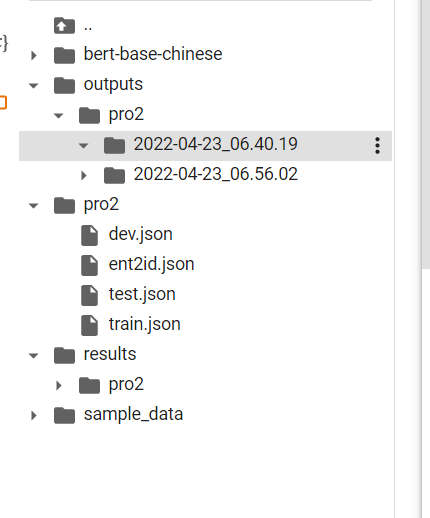

文件用于预测cullener，其中测试集的数据来自于验证集的后500条

In [1]:
!sudo apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/bert-base-chinese
!cd bert-base-chinese/
!git lfs install


Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'bert-base-chinese'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 42 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.
Filtering content: 100% (3/3), 1.20 GiB | 114.99 MiB/s, done.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [2]:
!unzip -q pro2.zip

unzip:  cannot find or open pro2.zip, pro2.zip.zip or pro2.zip.ZIP.


## utils

In [3]:
"""
Date: 2021-06-01 22:29:43
LastEditors: GodK
LastEditTime: 2021-07-31 19:30:18
"""
import torch


def multilabel_categorical_crossentropy(y_pred, y_true):
    """
    https://kexue.fm/archives/7359
    """
    y_pred = (1 - 2 * y_true) * y_pred  # -1 -> pos classes, 1 -> neg classes
    y_pred_neg = y_pred - y_true * 1e12  # mask the pred outputs of pos classes
    y_pred_pos = (y_pred - (1 - y_true) * 1e12)  # mask the pred outputs of neg classes
    zeros = torch.zeros_like(y_pred[..., :1])
    y_pred_neg = torch.cat([y_pred_neg, zeros], dim=-1)
    y_pred_pos = torch.cat([y_pred_pos, zeros], dim=-1)
    neg_loss = torch.logsumexp(y_pred_neg, dim=-1)
    pos_loss = torch.logsumexp(y_pred_pos, dim=-1)

    return (neg_loss + pos_loss).mean()


class Preprocessor(object):
    def __init__(self, tokenizer, add_special_tokens=True):
        super(Preprocessor, self).__init__()
        self.tokenizer = tokenizer
        self.add_special_tokens = add_special_tokens

    def get_ent2token_spans(self, text, entity_list):
        """实体列表转为token_spans

        Args:
            text (str): 原始文本
            entity_list (list): [(start, end, ent_type),(start, end, ent_type)...]
        """
        ent2token_spans = []

        inputs = self.tokenizer(text, add_special_tokens=self.add_special_tokens, return_offsets_mapping=True)
        token2char_span_mapping = inputs["offset_mapping"]
        text2tokens = self.tokenizer.tokenize(text, add_special_tokens=self.add_special_tokens)

        for ent_span in entity_list:
            ent = text[ent_span[0]:ent_span[1] + 1]
            ent2token = self.tokenizer.tokenize(ent, add_special_tokens=False)

            # 寻找ent的token_span
            token_start_indexs = [i for i, v in enumerate(text2tokens) if v == ent2token[0]]

            token_end_indexs = [i for i, v in enumerate(text2tokens) if v == ent2token[-1]]

            token_start_index = list(filter(lambda x: token2char_span_mapping[x][0] == ent_span[0], token_start_indexs))
            token_end_index = list(filter(lambda x: token2char_span_mapping[x][-1] - 1 == ent_span[1], token_end_indexs))  # token2char_span_mapping[x][-1]-1 减1是因为原始的char_span是闭区间，而token2char_span是开区间

            if len(token_start_index) == 0 or len(token_end_index) == 0:
                # print(f'[{ent}] 无法对应到 [{text}] 的token_span，已丢弃')
                continue
            token_span = (token_start_index[0], token_end_index[0], ent_span[2])

            ent2token_spans.append(token_span)
        return ent2token_spans


## Global_pointer.py

In [4]:
"""
Date: 2021-06-02 00:33:09
LastEditors: GodK
"""
import sys

sys.path.append("../")

import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.length = len(data)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.length


class DataMaker(object):
    def __init__(self, tokenizer, add_special_tokens = True):
        super().__init__()
        self.tokenizer = tokenizer
        self.add_special_tokens = add_special_tokens
        self.preprocessor = Preprocessor(tokenizer, self.add_special_tokens)

    def generate_inputs(self, datas, max_seq_len, ent2id, data_type="train"):
        """生成喂入模型的数据

        Args:
            datas (list): json格式的数据[{'text':'','entity_list':[(start,end,ent_type),()]}]
            max_seq_len (int): 句子最大token数量
            ent2id (dict): ent到id的映射
            data_type (str, optional): data类型. Defaults to "train".

        Returns:
            list: [(sample, input_ids, attention_mask, token_type_ids, labels),(),()...]
        """

        ent_type_size = len(ent2id)  # 实体类别

        all_inputs = []
        for sample in datas:
            inputs = self.tokenizer(
                sample["text"],
                max_length=max_seq_len,
                truncation=True,
                padding='max_length'
            )

            labels = None
            if data_type != "test":
                ent2token_spans = self.preprocessor.get_ent2token_spans(
                    sample["text"], sample["entity_list"]
                )
                labels = np.zeros((ent_type_size, max_seq_len, max_seq_len))
                for start, end, label in ent2token_spans:
                    labels[ent2id[label], start, end] = 1
            inputs["labels"] = labels

            input_ids = torch.tensor(inputs["input_ids"]).long()
            attention_mask = torch.tensor(inputs["attention_mask"]).long()
            token_type_ids = torch.tensor(inputs["token_type_ids"]).long()
            if labels is not None:
                labels = torch.tensor(inputs["labels"]).long()

            sample_input = (sample, input_ids, attention_mask, token_type_ids, labels)

            all_inputs.append(sample_input)
        return all_inputs
    
    def generate_batch(self, batch_data, max_seq_len, ent2id, data_type="train",):
        batch_data = self.generate_inputs(batch_data, max_seq_len, ent2id, data_type)
        sample_list = []
        input_ids_list = []
        attention_mask_list = []
        token_type_ids_list = []
        labels_list = []
        
        for sample in batch_data:
            sample_list.append(sample[0])
            input_ids_list.append(sample[1])
            attention_mask_list.append(sample[2])
            token_type_ids_list.append(sample[3])
            if data_type != "test":
                labels_list.append(sample[4])
        
        batch_input_ids = torch.stack(input_ids_list, dim=0)
        batch_attention_mask = torch.stack(attention_mask_list, dim=0)
        batch_token_type_ids = torch.stack(token_type_ids_list, dim=0)
        batch_labels = torch.stack(labels_list, dim=0) if data_type!="test" else None
        
        return sample_list, batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_labels
    
    def decode_ent(self, pred_matrix):
        pass

class MetricsCalculator(object):
    def __init__(self):
        super().__init__()
    
    def get_sample_f1(self, y_pred, y_true):
        y_pred = torch.gt(y_pred, 0).float()
        return 2 * torch.sum(y_true * y_pred) / torch.sum(y_true + y_pred)
    
    def get_sample_precision(self, y_pred, y_true):
        y_pred = torch.gt(y_pred, 0).float()
        return torch.sum(y_pred[y_true == 1]) / (y_pred.sum()+1)
    
    def get_evaluate_fpr(self, y_pred, y_true):
        y_pred = y_pred.cpu().numpy()
        y_true = y_true.cpu().numpy()
        pred = []
        true = []
        for b, l, start, end in zip(*np.where(y_pred>0)):
            pred.append((b, l, start, end))
        for b, l, start, end in zip(*np.where(y_true>0)):
            true.append((b, l, start, end))

        R = set(pred)
        T = set(true)
        X = len(R & T)+1e-5
        Y = len(R)+1e-5
        Z = len(T)+1e-5
        f1, precision, recall = 2 * X / (Y + Z), X / Y, X / Z
        return f1, precision, recall
    
    


class GlobalPointer(nn.Module):
    def __init__(self, encoder, ent_type_size, inner_dim, RoPE=True):
        super().__init__()
        self.encoder = encoder
        self.ent_type_size = ent_type_size
        self.inner_dim = inner_dim
        self.hidden_size = encoder.config.hidden_size
        self.dense = nn.Linear(self.hidden_size, self.ent_type_size * self.inner_dim * 2)

        self.RoPE = RoPE
    
    
    def sinusoidal_position_embedding(self, batch_size, seq_len, output_dim):
        position_ids = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(-1)

        indices = torch.arange(0, output_dim // 2, dtype=torch.float)
        indices = torch.pow(10000, -2 * indices / output_dim)
        embeddings = position_ids * indices
        embeddings = torch.stack([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        embeddings = embeddings.repeat((batch_size, *([1]*len(embeddings.shape))))
        embeddings = torch.reshape(embeddings, (batch_size, seq_len, output_dim))
        embeddings = embeddings.to(self.device)
        return embeddings
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        self.device = input_ids.device
        
        context_outputs = self.encoder(input_ids, attention_mask, token_type_ids)
        # last_hidden_state:(batch_size, seq_len, hidden_size)
        last_hidden_state = context_outputs[0]

        batch_size = last_hidden_state.size()[0]
        seq_len = last_hidden_state.size()[1]

        # outputs:(batch_size, seq_len, ent_type_size*inner_dim*2)
        outputs = self.dense(last_hidden_state)
        outputs = torch.split(outputs, self.inner_dim * 2, dim=-1)
        # outputs:(batch_size, seq_len, ent_type_size, inner_dim*2)
        outputs = torch.stack(outputs, dim=-2)
        # qw,kw:(batch_size, seq_len, ent_type_size, inner_dim)
        qw, kw = outputs[...,:self.inner_dim], outputs[...,self.inner_dim:] # TODO:修改为Linear获取？

        if self.RoPE:
            # pos_emb:(batch_size, seq_len, inner_dim)
            pos_emb = self.sinusoidal_position_embedding(batch_size, seq_len, self.inner_dim)
            # cos_pos,sin_pos: (batch_size, seq_len, 1, inner_dim)
            cos_pos = pos_emb[..., None, 1::2].repeat_interleave(2, dim=-1)
            sin_pos = pos_emb[..., None,::2].repeat_interleave(2, dim=-1)
            qw2 = torch.stack([-qw[..., 1::2], qw[...,::2]], -1)
            qw2 = qw2.reshape(qw.shape)
            qw = qw * cos_pos + qw2 * sin_pos
            kw2 = torch.stack([-kw[..., 1::2], kw[...,::2]], -1)
            kw2 = kw2.reshape(kw.shape)
            kw = kw * cos_pos + kw2 * sin_pos
            
        # logits:(batch_size, ent_type_size, seq_len, seq_len)
        logits = torch.einsum('bmhd,bnhd->bhmn', qw, kw)

        # padding mask
        pad_mask = attention_mask.unsqueeze(1).unsqueeze(1).expand(batch_size, self.ent_type_size, seq_len, seq_len)
        # pad_mask_h = attention_mask.unsqueeze(1).unsqueeze(-1).expand(batch_size, self.ent_type_size, seq_len, seq_len)
        # pad_mask = pad_mask_v&pad_mask_h
        logits = logits*pad_mask - (1-pad_mask)*1e12

        # 排除下三角
        mask = torch.tril(torch.ones_like(logits), -1) 
        logits = logits - mask * 1e12
        

        
        return logits/self.inner_dim**0.5



## config.py

In [15]:
"""
Date: 2021-06-01 17:18:25
LastEditors: GodK
"""
import time

common = {
    "exp_name": "pro2",
    "encoder": "BERT",
    "data_home": "",
    "bert_path": "bert-base-chinese",  # bert-base-cased， bert-base-chinese
    "run_type": "train",  # train,eval
    "f1_2_save": 0.5,  # 存模型的最低f1值
    "logger": "default"  # wandb or default，default意味着只输出日志到控制台
}

# wandb的配置，只有在logger=wandb时生效。用于可视化训练过程
wandb_config = {
    "run_name": time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime()),
    "log_interval": 10
}

train_config = {
    "train_data": "train.json",
    "valid_data": "dev.json",
    "ent2id": "ent2id.json",
    "path_to_save_model": "./outputs",  # 在logger不是wandb时生效
    "hyper_parameters": {
        "lr": 5e-5,
        "batch_size": 32,
        "epochs": 10,
        "seed": 2333,
        "max_seq_len": 128,
        "scheduler": "CAWR"
    }
}

eval_config = {
    "model_state_dir": "./outputs/pro2/",  # 预测时注意填写模型路径（时间tag文件夹）
    "run_id": "",
    "last_k_model": 1,  # 取倒数第几个model_state
    "test_data": "test.json",
    "ent2id": "ent2id.json",
    "save_res_dir": "results",
    "hyper_parameters": {
        "batch_size": 16,
        "max_seq_len": 512,
    }

}

cawr_scheduler = {
    # CosineAnnealingWarmRestarts
    "T_mult": 1,
    "rewarm_epoch_num": 2,
}
step_scheduler = {
    # StepLR
    "decay_rate": 0.999,
    "decay_steps": 100,
}

# ---------------------------------------------
train_config["hyper_parameters"].update(**cawr_scheduler, **step_scheduler)
train_config = {**train_config, **common, **wandb_config}
eval_config = {**eval_config, **common}


## evaluate.py

In [6]:
!pip install wandb
!pip install transformers

     |████████████████████████████████| 1.8 MB 8.2 MB/s 
     |████████████████████████████████| 144 kB 53.2 MB/s 
     |████████████████████████████████| 181 kB 52.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e39da93a1c1d8cd2639c49a053dd5a3bd98e659952aeb8f44bd760f43ef34e30
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
     |████████████████████████████████| 4.0 MB 9.7 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 58.2 MB/s 
     |████████████████████████████████| 6.6 MB 35.8 MB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## train.py

In [16]:

"""
Date: 2021-05-31 19:50:58
LastEditors: GodK
"""

import os

import sys
import torch
import json
from transformers import BertTokenizerFast, BertModel
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import glob
import wandb
import time

config = train_config
hyper_parameters = config["hyper_parameters"]

os.environ["TOKENIZERS_PARALLELISM"] = "true"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'
config["num_workers"] = 6 if sys.platform.startswith("linux") else 0

# for reproductivity
torch.manual_seed(hyper_parameters["seed"])  # pytorch random seed
torch.backends.cudnn.deterministic = True

if config["logger"] == "wandb" and config["run_type"] == "train":
    # init wandb
    wandb.init(project="GlobalPointer_" + config["exp_name"],
               config=hyper_parameters  # Initialize config
               )
    wandb.run.name = config["run_name"] + "_" + wandb.run.id

    model_state_dict_dir = wandb.run.dir
    logger = wandb
else:
    model_state_dict_dir = os.path.join(config["path_to_save_model"], config["exp_name"],
                                        time.strftime("%Y-%m-%d_%H.%M.%S", time.gmtime()))
    if not os.path.exists(model_state_dict_dir):
        os.makedirs(model_state_dict_dir)

tokenizer = BertTokenizerFast.from_pretrained(config["bert_path"], add_special_tokens=True, do_lower_case=False)


def load_data(data_path, data_type="train"):
    """读取数据集

    Args:
        data_path (str): 数据存放路径
        data_type (str, optional): 数据类型. Defaults to "train".

    Returns:
        (json): train和valid中一条数据格式：{"text":"","entity_list":[(start, end, label), (start, end, label)...]}
    """
    if data_type == "train" or data_type == "valid":
        # datas = []
        # with open(data_path, encoding="utf-8") as f:
        #     for line in f:
        #         line = json.loads(line)
        #         item = {}
        #         item["text"] = line["text"]
        #         item["entity_list"] = []
        #         for k, v in line['label'].items():
        #             for spans in v.values():
        #                 for start, end in spans:
        #                     item["entity_list"].append((start, end, k))
        #
        #         datas.append(item)
        datas = []
        with open(data_path, encoding="utf-8") as f:
            for line in f.readlines():
                line = json.loads(line)
                item = {}
                item["text"] = line["text"]
                item["entity_list"] = []
                for k, v in line['label'].items():
                    for k_, span in v.items():
                        for spans in span:
                            item["entity_list"].append((spans[0], spans[1], k))

                datas.append(item)
        return datas
    else:
        return json.load(open(data_path, encoding="utf-8"))


ent2id_path = os.path.join(config["data_home"], config["exp_name"], config["ent2id"])
ent2id = load_data(ent2id_path, "ent2id")
ent_type_size = len(ent2id)


def data_generator(data_type="train"):
    """
    读取数据，生成DataLoader。
    """

    if data_type == "train":
        train_data_path = os.path.join(config["data_home"], config["exp_name"], config["train_data"])
        train_data = load_data(train_data_path, "train")
        print('train_data_length',len(train_data))
        print('examples',train_data[:3])
        valid_data_path = os.path.join(config["data_home"], config["exp_name"], config["valid_data"])
        valid_data = load_data(valid_data_path, "valid")
    elif data_type == "valid":
        valid_data_path = os.path.join(config["data_home"], config["exp_name"], config["valid_data"])
        valid_data = load_data(valid_data_path, "valid")
        train_data = []

    all_data = train_data + valid_data

    # TODO:句子截取
    max_tok_num = 0
    for sample in all_data:
        tokens = tokenizer(sample["text"])["input_ids"]
        max_tok_num = max(max_tok_num, len(tokens))
    assert max_tok_num <= hyper_parameters["max_seq_len"], f'数据文本最大token数量{max_tok_num}超过预设{hyper_parameters["max_seq_len"]}'
    max_seq_len = min(max_tok_num, hyper_parameters["max_seq_len"])

    data_maker = DataMaker(tokenizer)

    if data_type == "train":
        # train_inputs = data_maker.generate_inputs(train_data, max_seq_len, ent2id)
        # valid_inputs = data_maker.generate_inputs(valid_data, max_seq_len, ent2id)
        train_dataloader = DataLoader(MyDataset(train_data),
                                      batch_size=hyper_parameters["batch_size"],
                                      shuffle=True,
                                      num_workers=config["num_workers"],
                                      drop_last=False,
                                      collate_fn=lambda x: data_maker.generate_batch(x, max_seq_len, ent2id)
                                      )
        valid_dataloader = DataLoader(MyDataset(valid_data),
                                      batch_size=hyper_parameters["batch_size"],
                                      shuffle=True,
                                      num_workers=config["num_workers"],
                                      drop_last=False,
                                      collate_fn=lambda x: data_maker.generate_batch(x, max_seq_len, ent2id)
                                      )
        # for batch in train_dataloader:
        #     print(batch[1].shape)
        #     print(hyper_parameters["batch_size"])
        #     break
        return train_dataloader, valid_dataloader
    elif data_type == "valid":
        # valid_inputs = data_maker.generate_inputs(valid_data, max_seq_len, ent2id)
        valid_dataloader = DataLoader(MyDataset(valid_data),
                                      batch_size=hyper_parameters["batch_size"],
                                      shuffle=True,
                                      num_workers=config["num_workers"],
                                      drop_last=False,
                                      collate_fn=lambda x: data_maker.generate_batch(x, max_seq_len, ent2id)
                                      )
        return valid_dataloader


metrics = MetricsCalculator()


def train_step(batch_train, model, optimizer, criterion):
    # batch_input_ids:(batch_size, seq_len)    batch_labels:(batch_size, ent_type_size, seq_len, seq_len)
    batch_samples, batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_labels = batch_train
    batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_labels = (batch_input_ids.to(device),
                                                                                 batch_attention_mask.to(device),
                                                                                 batch_token_type_ids.to(device),
                                                                                 batch_labels.to(device)
                                                                                 )

    logits = model(batch_input_ids, batch_attention_mask, batch_token_type_ids)

    loss = criterion(logits, batch_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sample_precision = metrics.get_sample_precision(logits, batch_labels)
    sample_f1 = metrics.get_sample_f1(logits, batch_labels)

    return loss.item(), sample_precision.item(), sample_f1.item()


encoder = BertModel.from_pretrained(config["bert_path"])
model = GlobalPointer(encoder, ent_type_size, 64)
model = model.to(device)

if config["logger"] == "wandb" and config["run_type"] == "train":
    wandb.watch(model)


def train(model, dataloader, epoch, optimizer):
    model.train()

    # loss func
    def loss_fun(y_true, y_pred):
        """
        y_true:(batch_size, ent_type_size, seq_len, seq_len)
        y_pred:(batch_size, ent_type_size, seq_len, seq_len)
        """
        batch_size, ent_type_size = y_pred.shape[:2]
        y_true = y_true.reshape(batch_size * ent_type_size, -1)
        y_pred = y_pred.reshape(batch_size * ent_type_size, -1)
        loss = multilabel_categorical_crossentropy(y_true, y_pred)
        return loss

    # scheduler
    if hyper_parameters["scheduler"] == "CAWR":
        T_mult = hyper_parameters["T_mult"]
        rewarm_epoch_num = hyper_parameters["rewarm_epoch_num"]
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                         len(train_dataloader) * rewarm_epoch_num,
                                                                         T_mult)
    elif hyper_parameters["scheduler"] == "Step":
        decay_rate = hyper_parameters["decay_rate"]
        decay_steps = hyper_parameters["decay_steps"]
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

    total_loss, total_precision, total_f1 = 0., 0., 0.
    for batch_ind, batch_data in enumerate(dataloader):

        loss, precision, f1 = train_step(batch_data, model, optimizer, loss_fun)

        total_loss += loss
        total_precision += precision
        total_f1 += f1

        avg_loss = total_loss / (batch_ind + 1)
        scheduler.step()

        avg_precision = total_precision / (batch_ind + 1)
        avg_f1 = total_f1 / (batch_ind + 1)
        if batch_ind % 200==0:
          print(
              f'Project:{config["exp_name"]}, Epoch: {epoch + 1}/{hyper_parameters["epochs"]}, Batch: {batch_ind + 1}/{len(dataloader)}, loss: {avg_loss}, precision: {avg_precision}, f1:{avg_f1}, lr: {optimizer.param_groups[0]["lr"]}')
        if config["logger"] == "wandb" and batch_ind % config["log_interval"] == 0:
            logger.log({
                "epoch": epoch,
                "train_loss": avg_loss,
                "train_precision": avg_precision,
                "train_f1": avg_f1,
                "learning_rate": optimizer.param_groups[0]['lr'],
            })


def valid_step(batch_valid, model):
    batch_samples, batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_labels = batch_valid
    batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_labels = (batch_input_ids.to(device),
                                                                                 batch_attention_mask.to(device),
                                                                                 batch_token_type_ids.to(device),
                                                                                 batch_labels.to(device)
                                                                                 )
    with torch.no_grad():
        logits = model(batch_input_ids, batch_attention_mask, batch_token_type_ids)
    sample_f1, sample_precision, sample_recall = metrics.get_evaluate_fpr(logits, batch_labels)

    return sample_f1, sample_precision, sample_recall


def valid(model, dataloader):
    model.eval()

    total_f1, total_precision, total_recall = 0., 0., 0.
    for batch_data in tqdm(dataloader, desc="Validating"):
        f1, precision, recall = valid_step(batch_data, model)

        total_f1 += f1
        total_precision += precision
        total_recall += recall

    avg_f1 = total_f1 / (len(dataloader))
    avg_precision = total_precision / (len(dataloader))
    avg_recall = total_recall / (len(dataloader))
    print("******************************************")
    print(f'avg_precision: {avg_precision}, avg_recall: {avg_recall}, avg_f1: {avg_f1}')
    print("******************************************")
    if config["logger"] == "wandb":
        logger.log({"valid_precision": avg_precision, "valid_recall": avg_recall, "valid_f1": avg_f1})
    return avg_f1


if __name__ == '__main__':
    if config["run_type"] == "train":
        train_dataloader, valid_dataloader = data_generator()
        print('len_train_dataloader',len(train_dataloader))
        # optimizer
        init_learning_rate = float(hyper_parameters["lr"])
        optimizer = torch.optim.Adam(model.parameters(), lr=init_learning_rate)

        max_f1 = 0.
        for epoch in range(hyper_parameters["epochs"]):
            train(model, train_dataloader, epoch, optimizer)
            valid_f1 = valid(model, valid_dataloader)
            if valid_f1 > max_f1:
                max_f1 = valid_f1
                if valid_f1 > config["f1_2_save"]:  # save the best model
                    modle_state_num = len(glob.glob(model_state_dict_dir + "/model_state_dict_*.pt"))
                    torch.save(model.state_dict(),
                               os.path.join(model_state_dict_dir, "model_state_dict_{}.pt".format(modle_state_num)))
            print(f"Best F1: {max_f1}")
            print("******************************************")
            if config["logger"] == "wandb":
                logger.log({"Best_F1": max_f1})
    elif config["run_type"] == "eval":
        evaluate()


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train_data_length 10748
examples [{'text': '浙商银行企业信贷部叶老桂博士则从另一个角度对五道门槛进行了解读。叶老桂认为，对目前国内商业银行而言，', 'entity_list': [(9, 11, 'name'), (0, 3, 'company')]}, {'text': '生生不息CSOL生化狂潮让你填弹狂扫', 'entity_list': [(4, 7, 'game')]}, {'text': '那不勒斯vs锡耶纳以及桑普vs热那亚之上呢？', 'entity_list': [(0, 3, 'organization'), (6, 8, 'organization'), (11, 12, 'organization'), (15, 17, 'organization')]}]
len_train_dataloader 336


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Project:pro2, Epoch: 1/10, Batch: 1/336, loss: 6.600592136383057, precision: 0.0002596285776235163, f1:0.0005189623916521668, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 1/10, Batch: 201/336, loss: 1.0347090218197648, precision: 0.5221999186135722, f1:0.3898638491414543, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 11.20it/s]


******************************************
avg_precision: 0.7194880021807883, avg_recall: 0.8028311059808583, avg_f1: 0.7578333078500072
******************************************
Best F1: 0.7578333078500072
******************************************
Project:pro2, Epoch: 2/10, Batch: 1/336, loss: 0.2776467800140381, precision: 0.8309859037399292, f1:0.7712418437004089, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 2/10, Batch: 201/336, loss: 0.22915260701333706, precision: 0.821239360529392, f1:0.788216386861469, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 10.36it/s]


******************************************
avg_precision: 0.7605774153240777, avg_recall: 0.7899067121083995, avg_f1: 0.7743630158828901
******************************************
Best F1: 0.7743630158828901
******************************************
Project:pro2, Epoch: 3/10, Batch: 1/336, loss: 0.16657279431819916, precision: 0.8805969953536987, f1:0.8740741014480591, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 3/10, Batch: 201/336, loss: 0.17360484273872565, precision: 0.8545729731445881, f1:0.8430472769547458, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 10.50it/s]


******************************************
avg_precision: 0.7587768930923325, avg_recall: 0.8078984911893782, avg_f1: 0.7816531776492889
******************************************
Best F1: 0.7816531776492889
******************************************
Project:pro2, Epoch: 4/10, Batch: 1/336, loss: 0.1914335936307907, precision: 0.8382353186607361, f1:0.8321167826652527, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 4/10, Batch: 201/336, loss: 0.13155619827891463, precision: 0.880441064858318, f1:0.8811883226555971, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 10.73it/s]


******************************************
avg_precision: 0.775344875867493, avg_recall: 0.7951844896011039, avg_f1: 0.7843824523690343
******************************************
Best F1: 0.7843824523690343
******************************************
Project:pro2, Epoch: 5/10, Batch: 1/336, loss: 0.06287578493356705, precision: 0.9305555820465088, f1:0.9436619877815247, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 5/10, Batch: 201/336, loss: 0.09993927193740706, precision: 0.9078553837923268, f1:0.9125213379883648, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 11.09it/s]

******************************************
avg_precision: 0.7569564923159408, avg_recall: 0.8149724836660062, avg_f1: 0.7843089997281117
******************************************
Best F1: 0.7843824523690343
******************************************


Project:pro2, Epoch: 6/10, Batch: 1/336, loss: 0.04793429374694824, precision: 0.939393937587738, f1:0.961240291595459, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 6/10, Batch: 201/336, loss: 0.074715699703984, precision: 0.9266110225696469, f1:0.9352318264951753, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 11.07it/s]

******************************************
avg_precision: 0.7670669653981453, avg_recall: 0.7908403853763878, avg_f1: 0.7777223110387479
******************************************
Best F1: 0.7843824523690343
******************************************


Project:pro2, Epoch: 7/10, Batch: 1/336, loss: 0.033512722700834274, precision: 0.9605262875556946, f1:0.9798657894134521, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 7/10, Batch: 201/336, loss: 0.05987925560616735, precision: 0.9392987510458154, f1:0.9496879556878882, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 10.59it/s]

******************************************
avg_precision: 0.7592416479967943, avg_recall: 0.8005817201643859, avg_f1: 0.7783956933384082
******************************************
Best F1: 0.7843824523690343
******************************************


Project:pro2, Epoch: 8/10, Batch: 1/336, loss: 0.04488106444478035, precision: 0.9459459185600281, f1:0.9655172228813171, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 8/10, Batch: 201/336, loss: 0.05019886844064021, precision: 0.9461606752813159, f1:0.9576916507820585, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 10.62it/s]


******************************************
avg_precision: 0.7647344773164042, avg_recall: 0.8088305096905986, avg_f1: 0.7851920355853806
******************************************
Best F1: 0.7851920355853806
******************************************
Project:pro2, Epoch: 9/10, Batch: 1/336, loss: 0.05707431584596634, precision: 0.9146341681480408, f1:0.9433962106704712, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 9/10, Batch: 201/336, loss: 0.04423216236430911, precision: 0.9518226607521968, f1:0.9637569924492148, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 10.67it/s]

******************************************
avg_precision: 0.7745565049286722, avg_recall: 0.773190332840184, avg_f1: 0.7729788361870369
******************************************
Best F1: 0.7851920355853806
******************************************


Project:pro2, Epoch: 10/10, Batch: 1/336, loss: 0.018417617306113243, precision: 0.9692307710647583, f1:0.984375, lr: 4.9999726806462766e-05
Project:pro2, Epoch: 10/10, Batch: 201/336, loss: 0.03338666553539572, precision: 0.9627969706829508, f1:0.9743371196647188, lr: 3.9751305608428205e-05


Validating: 100%|██████████| 27/27 [00:02<00:00, 11.02it/s]

******************************************
avg_precision: 0.7760020726286996, avg_recall: 0.7825586430911748, avg_f1: 0.7787655937166015
******************************************
Best F1: 0.7851920355853806
******************************************


In [17]:
"""
Date: 2021-06-11 13:54:00
LastEditors: GodK
LastEditTime: 2021-07-19 21:53:18
"""
import os
import sys
import torch
import json
from transformers import BertTokenizerFast, BertModel

from torch.utils.data import DataLoader, Dataset
import numpy as np

config = eval_config
hyper_parameters = config["hyper_parameters"]

os.environ["TOKENIZERS_PARALLELISM"] = "true"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config["num_workers"] = 6 if sys.platform.startswith("linux") else 0

# for reproductivity
torch.backends.cudnn.deterministic = True

tokenizer = BertTokenizerFast.from_pretrained(config["bert_path"], add_special_tokens=True, do_lower_case=False)


def load_data(data_path, data_type="test"):
    if data_type == "test":
        datas = []
        with open(data_path, encoding="utf-8") as f:
            for line in f:
                line = json.loads(line)
                datas.append(line)
        return datas
    else:
        return json.load(open(data_path, encoding="utf-8"))


ent2id_path = os.path.join(config["data_home"], config["exp_name"], config["ent2id"])
ent2id = load_data(ent2id_path, "ent2id")
ent_type_size = len(ent2id)


def data_generator(data_type="test"):
    """
    读取数据，生成DataLoader。
    """

    if data_type == "test":
        test_data_path = os.path.join(config["data_home"], config["exp_name"], config["test_data"])
        test_data = load_data(test_data_path, "test")

    all_data = test_data

    # TODO:句子截取
    max_tok_num = 0
    for sample in all_data:
        tokens = tokenizer.tokenize(sample["text"])
        max_tok_num = max(max_tok_num, len(tokens))
    assert max_tok_num <= hyper_parameters["max_seq_len"], f'数据文本最大token数量{max_tok_num}超过预设{hyper_parameters["max_seq_len"]}'
    max_seq_len = min(max_tok_num, hyper_parameters["max_seq_len"])

    data_maker = DataMaker(tokenizer)

    if data_type == "test":
        # test_inputs = data_maker.generate_inputs(test_data, max_seq_len, ent2id, data_type="test")
        test_dataloader = DataLoader(MyDataset(test_data),
                                     batch_size=hyper_parameters["batch_size"],
                                     shuffle=False,
                                     num_workers=config["num_workers"],
                                     drop_last=False,
                                     collate_fn=lambda x: data_maker.generate_batch(x, max_seq_len, ent2id,
                                                                                    data_type="test")
                                     )
        return test_dataloader


def decode_ent(text, pred_matrix, tokenizer, threshold=0):
    # print(text)
    token2char_span_mapping = tokenizer(text, return_offsets_mapping=True)["offset_mapping"]
    id2ent = {id: ent for ent, id in ent2id.items()}
    pred_matrix = pred_matrix.cpu().numpy()
    ent_list = {}
    for ent_type_id, token_start_index, token_end_index in zip(*np.where(pred_matrix > threshold)):
        ent_type = id2ent[ent_type_id]
        ent_char_span = [token2char_span_mapping[token_start_index][0], token2char_span_mapping[token_end_index][1]]
        ent_text = text[ent_char_span[0]:ent_char_span[1]]

        ent_type_dict = ent_list.get(ent_type, {})
        ent_text_list = ent_type_dict.get(ent_text, [])
        ent_text_list.append(ent_char_span)
        ent_type_dict.update({ent_text: ent_text_list})
        ent_list.update({ent_type: ent_type_dict})
    # print(ent_list)
    return ent_list


def predict(dataloader, model):
    predict_res = []

    model.eval()
    for batch_data in dataloader:
        batch_samples, batch_input_ids, batch_attention_mask, batch_token_type_ids, _ = batch_data
        batch_input_ids, batch_attention_mask, batch_token_type_ids = (batch_input_ids.to(device),
                                                                       batch_attention_mask.to(device),
                                                                       batch_token_type_ids.to(device),
                                                                       )
        with torch.no_grad():
            batch_logits = model(batch_input_ids, batch_attention_mask, batch_token_type_ids)

        for ind in range(len(batch_samples)):
            gold_sample = batch_samples[ind]
            text = gold_sample["text"]
            text_id = gold_sample["id"]
            pred_matrix = batch_logits[ind]
            labels = decode_ent(text, pred_matrix, tokenizer)
            predict_res.append({"id": text_id, "text": text, "label": labels})
    return predict_res


def load_model():
    # model_state_dir = config["model_state_dir"]
    model_state_dir = 'outputs/pro2/2022-04-23_07.09.44'
    model_state_list = sorted(filter(lambda x: "model_state" in x, os.listdir(model_state_dir)),
                              key=lambda x: int(x.split(".")[0].split("_")[-1]))
    last_k_model = config["last_k_model"]
    model_state_path = os.path.join(model_state_dir, model_state_list[-last_k_model])

    encoder = BertModel.from_pretrained(config["bert_path"])
    model = GlobalPointer(encoder, ent_type_size, 64)
    model.load_state_dict(torch.load(model_state_path))
    model = model.to(device)

    return model


def evaluate():
    test_dataloader = data_generator(data_type="test")

    model = load_model()

    predict_res = predict(test_dataloader, model)

    if not os.path.exists(os.path.join(config["save_res_dir"], config["exp_name"])):
        os.mkdir(os.path.join(config["save_res_dir"], config["exp_name"]))
    save_path = os.path.join(config["save_res_dir"], config["exp_name"], "predict_result.json")
    # json.dump(predict_res, open(save_path, "w", encoding="utf-8"), ensure_ascii=False)
    with open(save_path, "w", encoding="utf-8") as f:
        for item in predict_res:
            f.write(json.dumps(item, ensure_ascii=False) + "\n")


if __name__ == '__main__':
    evaluate()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializ